# Milestone 1 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Alyssa Wilson<br>

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from bs4 import BeautifulSoup
import urllib
from urllib import urlopen
import threading
from threading import Timer
from time import time, sleep
import io
import seaborn as sns

In this project, we want to predict movie genres using movie posters and other movie metadata. The two sources of data are TMDb and IMDb, which will be accessed using the TMDb API and IMDbPY package respectively.

## Our Favorite Movie

Our favorite movie is "The Shawshank Redemption". Using the TMDb API, we obtain this movie's genre and poster path, which we link to below.

In [22]:
def get_movie(movie_id):
    url_string="https://api.themoviedb.org/3/movie/"+str(movie_id)+"?api_key=1cc37144dc84322526d9b17191ff00bb&language=en-US"
    url=urlopen(url_string)
    content = url.read()
    data=json.loads(content)
    if 'status_code' in data:
        pass
    else:
        line=u""
        line=line+u"\t"+str(data['poster_path']).decode('utf8') ## poster path
        ## genres
        genres_string=""
        for g in data['genres']:
            genres_string=genres_string+","+g['name']
        line=line+u","+genres_string
        return line
    
get_movie(278)

u'\t/9O7gLzmreU0nGkIB6K3BsJbzvNv.jpg,,Drama,Crime'

![](https://image.tmdb.org/t/p/w185/9O7gLzmreU0nGkIB6K3BsJbzvNv.jpg)

We compare this against the movie's genre listings on IMDb. In this case, they are exactly the same (although they may not necessarily be for other movies).
- Genre tags of "The Shawshank Redemption" in TMDb: Drama, Crime
- Genre tags of "The Shawshank Redemption" in IMDb: Drama, Crime

---

## Top 10 Movies of 2016

In [13]:
url = urlopen("https://api.themoviedb.org/3/genre/movie/list?api_key=1cc37144dc84322526d9b17191ff00bb&language=en-US")
content = url.read()
data = json.loads(content)

genre_dict={}
for x in data['genres']:
    genre_dict[x['id']]=x['name']

genre_dict

{12: u'Adventure',
 14: u'Fantasy',
 16: u'Animation',
 18: u'Drama',
 27: u'Horror',
 28: u'Action',
 35: u'Comedy',
 36: u'History',
 37: u'Western',
 53: u'Thriller',
 80: u'Crime',
 99: u'Documentary',
 878: u'Science Fiction',
 9648: u'Mystery',
 10402: u'Music',
 10749: u'Romance',
 10751: u'Family',
 10752: u'War',
 10770: u'TV Movie'}

We see that TMDb uses a total of 19 categories for their genre classification, as listed above. Now, we retrieve a list of the top 10 most popular movies in 2016 and their genres from TMDb, as shown below.

In [14]:
url = urlopen("https://api.themoviedb.org/3/discover/movie?api_key=1cc37144dc84322526d9b17191ff00bb&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016")
content = url.read()
data = json.loads(content)

movie_dict={}
count=0
for x in data['results']:
    count+=1
    genre_ids=x['genre_ids']
    genre_list=[]
    for i in genre_ids:
        genre_list.append(str(genre_dict[i]))
    movie_dict[str(x['title'])]=genre_list
    if count>=10:
        break
        
movie_dict

{'Arrival': ['Drama', 'Science Fiction'],
 'Captain America: Civil War': ['Action', 'Science Fiction'],
 'Deadpool': ['Action', 'Adventure', 'Comedy', 'Romance'],
 'Doctor Strange': ['Action', 'Adventure', 'Fantasy', 'Science Fiction'],
 'Fantastic Beasts and Where to Find Them': ['Adventure', 'Action', 'Fantasy'],
 'Finding Dory': ['Adventure', 'Animation', 'Comedy', 'Family'],
 'Rogue One: A Star Wars Story': ['Action', 'Drama', 'Science Fiction', 'War'],
 'Sing': ['Animation', 'Comedy', 'Drama', 'Family', 'Music'],
 'Underworld: Blood Wars': ['Action', 'Horror'],
 'Zootopia': ['Animation', 'Adventure', 'Family', 'Comedy']}

---

## Data Scraping

We used the TMDb API to extract information on movies from `tmdb_id` of 1 to 10000. Half of the `tmdb_id`'s were empty, returning about 5000 records.

We note that the `tmdb_id`'s run up to about 600000. Given that the TMDb API only allows 40 queries every 10 seconds, we estimate it will take us about 42 hours to scrape the entire database. 

Therefore, for the purposes of this milestone and EDA, we will simply use this limited sample of 5000 records, in view of time constraints. We checked the release years of these movies and they do represent a good mix of old and recent movies. Moving forward, we will scrape the full database of movies to prepare our training data in Milestone 2.

In [16]:
class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [ ]:
target = io.open("G:/data/raw/information/tmdb_movie_info.txt", 'w',encoding="utf8")
line=u"tmdb_id\timdb_id\ttitle\tplot\tposter_path\trelease_date\tbudget\trevenue\truntime\tpopularity\tuser_rating\tproduction_company\tgenres"
target.write(line+'\n')
for i in range(250):
    startTime = time()
    movie_ids=np.arange(40*i+1,40*(i+1)+1)
    for movie_id in movie_ids:
        url_string="https://api.themoviedb.org/3/movie/"+str(movie_id)+"?api_key=1cc37144dc84322526d9b17191ff00bb&language=en-US"
        url=urlopen(url_string)
        content = url.read()
        data=json.loads(content)
        if 'status_code' in data:
            pass
        else:
            line=u""
            line=line+str(data['id']).decode('utf8') #tmdb_id
            line=line+u"\t"+data['imdb_id'].replace("t","") #imdb_id
            line=line+u"\t"+data['title'] ## title
            line=line+u"\t"+data['overview'] ##plot
            line=line+u"\t"+str(data['poster_path']).decode('utf8') ## poster path
            line=line+u"\t"+data['release_date'] ## release date
            line=line+u"\t"+str(data['budget']).decode('utf8') ## budget
            line=line+u"\t"+str(data['revenue']).decode('utf8') ##revenue
            line=line+u"\t"+str(data['runtime']).decode('utf8') ##runtime
            line=line+u"\t"+str(data['popularity']).decode('utf8')##tmdb popularity
            line=line+u"\t"+str(data['vote_average']).decode('utf8') ## user rating
            ## production company
            company_string=""
            for c in data['production_companies']:
                company_string=company_string+","+c['name']
            line=line+u"\t"+company_string

            ## genres
            genres_string=""
            for g in data['genres']:
                genres_string=genres_string+","+g['name']
            line=line+u"\t"+genres_string
            target.write(line+'\n')
    endTime = time()-startTime
    target.flush()
    print i,endTime
    if endTime<10.0:
        sleep(10.0-endTime)
    else:
        continue

target.close()

You can view the raw data file we gathered on our GitHub repository here.

---

## Heatmap of Genre Correlation

In this section, we want to generate a heatmap of the movie genre pairs, to see which genres tend to go together. We pre-processed the data we scraped earlier into a csv file, with columns of binary flags for the 19 TMDb genres, and about 5000 rows of movies.

In [3]:
# load csv file
genres = pd.read_csv('genres_10k.txt')

# view first few rows
genres.head()

,tmdb_id,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,TVMovie
0,616,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1302,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2364,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2940,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
4,3657,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
# drop "tmdb_id" column
genres = genres.drop('tmdb_id', axis=1)

# generate correlation matrix
corrmat = genres.corr()

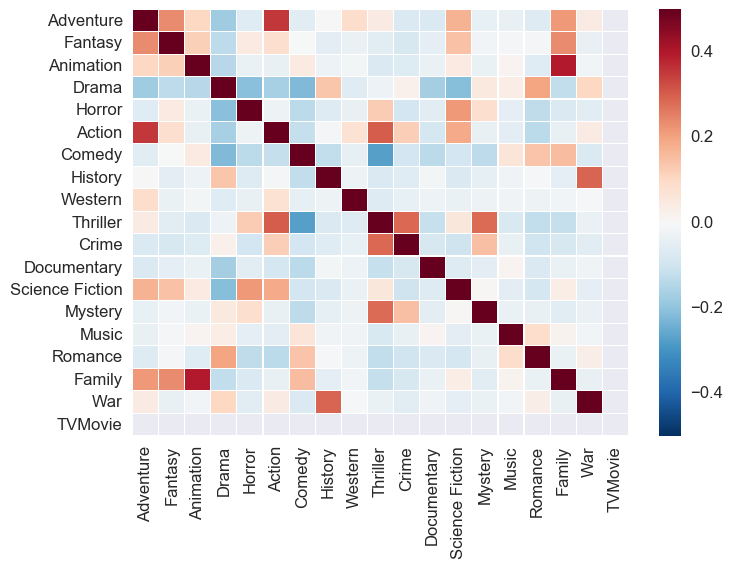

In [9]:
# set appropriate font and dpi
sns.set(font_scale=1.2)
sns.set_style({"savefig.dpi": 100})

# plot heatmap
ax = sns.heatmap(corrmat, linewidths=.1, vmin=-0.5, vmax=0.5)

From the heatmap above, we see that the following pairs of genres tend to be strongly correlated: Action-Adventure, Animation-Family, Action-Thriller, History-War, Thriller-Crime and Thriller-Mystery. We might consider grouping these genres together in our model to reduce the number of outcome variable classes. 

In contrast, these pairs of genres are negatively correlated: Drama-Science Fiction and Comedy-Thriller.

We did not have any records tagged as "TVMovie".

---

## Potential Challenges & Questions

We forsee several challenges on this project, and plan to address them, as follows:
- TMDb and IMDb may have different genre tags for a particular movie. In addition, the lengths of their genre listings may differ. To deal with this issue, we may match the tags from both databases and only consider the intersection of the two sets. Alternatively, we may just use the genre tags from one database only. 
- There are too many genres, and some are closely related. We may collapse some of the genres together into one group. However, in analyzing the outcome variable, we still feel it is natural for most movies to have more than one genre, as it is difficult for a movie to fall neatly into one category. Therefore, we need a model that can handle multiple outcomes.
- There is an overwhelming amount of metadata available for each movie, especially on IMDb. Scraping and cleaning all of it will take a very long time. Instead, we will selectively choose variables we want to include in our model (discussed below).


We conducted a brainstorming session to think of features associated with movie genre, and based on our beliefs, we identified the following variables, which we will use in our model to supplement the posters:
- Title
- Plot summary / keywords
- Producer
- Director
- Writer
- Cast (top-billed n cast, listed by importance)
- Production company
- Release date
- Runtime
- Country of origin / language
- Budget
- Revenue
- Picture rating (eg. PG-13, R-21) (known as "certificates" on IMDb)
- Average user rating
- Whether the movie is a sequel or not

Questions we have are:
- How will we analyze textual information, such as titles and plot summaries?
- If we train 2 separate models, one using movie posters and the other using movie metadata, how do we combine their predictions, and how much weight should be given to each model? 

---

## Exploratory Data Analysis

In this section, we do a preliminary exploration of the data we have, looking for variables that are potential predictors of movie genre, and visualizing how they are associated with genre.

(Tim to fill this section with visualisations)

Other EDA questions we would like to explore include:
- Is length of movie title correlated with genre?
- etc.

---

## Next Steps

Moving onwards, we will complete the full wrangling and cleaning of data from TMDb and IMDb, including the posters. We intend to extract all movies in the TMDb database, then drop records that have missing poster paths and `imdb_id`'s. Then, we will extract the additional metadata we want for these movies from IMDb and match them to TMDb records based on `imdb_id`. We will decide how we want to regroup the genres and the exact forms of X's and Y's for the training and testing datasets.

---